In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, metrics
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'cifar-10-batches-py/test_batch'
    else:
        name = 'cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [4]:
rotations_num = 4
augment_num = 10

saved_name = 'selfsupervised'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [5]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [6]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [7]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

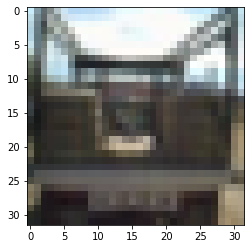

[1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


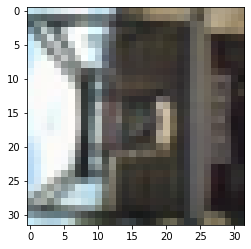

[0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


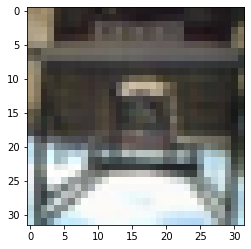

[0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


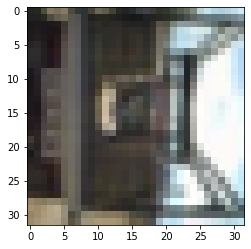

[0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [8]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [9]:
#combined_data = preprocess_input(combined_data)

In [10]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
            
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [11]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4, name='out_layer')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(rotations_num, kernel_regularizer=regularizers.l2(l = 0.0001), activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [12]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [13]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    
    return lr

In [14]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    
    return lr

In [15]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    if epoch == 10:
        return lr / 5.
    
    return lr

In [16]:
def lr_schedule_linear(epoch, lr):
    print(lr)
    if epoch < supervised_epochs // 2:
        return lr + (0.1 - 0.00001) / supervised_epochs * 2.
    else:
        return max(lr - (0.1 - 0.00001) / supervised_epochs * 2., 0.00001)
    
    return lr

In [17]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [129]:
log = train_feat()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Train on 240000 samples
Epoch 1/100
 13056/240000 [>.............................] - ETA: 4:55 - loss: 2.2665 - accuracy: 0.3283

KeyboardInterrupt: 

In [18]:
def get_cls_model(name = saved_name, use_features = True, percent = 100):
    if use_features:
        model = tf.keras.models.load_model(name)
    else:
        model = tf.keras.models.load_model('emptyResNet')
        
    if percent >= 50:
        l = model.get_layer(feature_layer).output
    else:
        l = model.get_layer(first_resnet_layer).output
        
    #model = tf.keras.models.load_model(cnn_name)
    #l = model.get_layer(feature_layer_cnn).output
    
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [19]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [ ]:
cls_train_features = train_cls(True)

In [ ]:
cls_no_train_features = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['acc'],
              feature_extracting_accuracy = cls_no_train_features.history['acc'])

In [ ]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_acc'],
              feature_extracting_accuracy = cls_no_train_features.history['val_acc'])

In [164]:
labelsPercent = [1, 2, 3, 5, 10, 25, 50, 100]

In [20]:
def shuffle_examples():
    #Перемешивание датасета для выбора размеченных экземпляров, т.к. выбираются первые n элементов
    for i in range(len(examplesForClass)):
        random.shuffle(examplesForClass[i])

In [21]:
def generate_labeled_unlabeled(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    #labeled_nums = [rotations_num * i for i in range(5000 - percent * 50, 5000)]
    labeled_nums = [i for i in range((5000 - percent * 50) * rotations_num, 5000 * rotations_num)]
    unlabeled_nums = [i for i in range((5000 - percent * 50) * rotations_num)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [22]:
def generate_augmented_labeled_unlabeled(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    #labeled_nums = [rotations_num * i for i in range(5000 - percent * 50, 5000)]
    labeled_nums = [i for i in range((5000 - percent * 50) * augment_num, 5000 * augment_num)]
    unlabeled_nums = [i for i in range((5000 - percent * 50) * augment_num)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [23]:
def self_supervised_train(unlabeled, percent, use_datagen = False, **kwargs):
    if percent >= 100:
        return None
    
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    if use_datagen:
        log = model.fit(kwargs['datagen'].flow(np.asarray([combined_data[i] for i in unlabeled]), 
                    np.asarray([combined_labels[i] for i in unlabeled]),
                    batch_size = selfsupervised_batch_size),
                    epochs = selfsupervised_epochs, 
                    steps_per_epoch = len(unlabeled) // selfsupervised_batch_size,
                    shuffle = True,
                    #callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray(combined_data[50000 * rotations_num:]), 
                                               np.asarray(combined_labels[50000 * rotations_num:])))
    else:    
        log = model.fit(np.asarray([combined_data[i] for i in unlabeled]) / 256., 
                    np.asarray([combined_labels[i] for i in unlabeled]), 
                    epochs = selfsupervised_epochs, 
                    batch_size = selfsupervised_batch_size, 
                    shuffle = True,
                    #callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)])  / 256., 
                                               np.asarray([combined_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    model.save(saved_name + "_" + str(percent))
    
    return log

In [24]:
def fine_tune(labeled, percent, train_features = True, use_features = True, use_datagen = False, **kwargs):
    #cls_model = get_cls_model(saved_name + "_" + str(percent))
    cls_model = get_cls_model(saved_name, use_features, percent)
    
    if not train_features:
        flag = False
        for l in cls_model.layers:
            l.trainable = flag
            if l.name == feature_layer or l.name == feature_layer_trained:
                flag = True
                
    cls_model.summary()
            
    cls_model.compile(optimizer = optimizers.Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
    if use_datagen:
        print('Datagen is used...')
        cls_log = cls_model.fit(kwargs['datagen'].flow(np.asarray([combined_data[i] for i in labeled]), 
                            np.asarray([true_labels[i] for i in labeled]),
                            batch_size = supervised_batch_size), 
                            epochs = supervised_epochs,
                            steps_per_epoch = len(labeled) // supervised_batch_size, 
                            shuffle = True,
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)]) / 256., 
                                               np.asarray([true_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    else:
        cls_log = cls_model.fit(np.asarray([augmented_data[i] for i in labeled]) / 256., 
                            np.asarray([augmented_labels[i] for i in labeled]), 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, 
                            shuffle = True,
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)])  / 256., 
                                               np.asarray([true_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    
    return cls_log

In [25]:
def get_empty_model():
    #Непредобученная модель на случай использования всей разметки
    model = get_conv_model()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.save(saved_name + "_100")
    
    return get_cls_model(saved_name + "_100")

In [26]:
def my_preprocess(data):
    output = data / 256.0
    return output

In [139]:
aug_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=4,
    height_shift_range=4,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=my_preprocess)
aug_datagen.fit(combined_data)

In [180]:
print(dir(tf.image))

['ResizeMethod', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'adjust_brightness', 'adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_jpeg_quality', 'adjust_saturation', 'central_crop', 'combined_non_max_suppression', 'convert_image_dtype', 'crop_and_resize', 'crop_to_bounding_box', 'decode_and_crop_jpeg', 'decode_bmp', 'decode_gif', 'decode_image', 'decode_jpeg', 'decode_png', 'draw_bounding_boxes', 'encode_jpeg', 'encode_png', 'extract_glimpse', 'extract_jpeg_shape', 'extract_patches', 'flip_left_right', 'flip_up_down', 'generate_bounding_box_proposals', 'grayscale_to_rgb', 'hsv_to_rgb', 'image_gradients', 'is_jpeg', 'non_max_suppression', 'non_max_suppression_overlaps', 'non_max_suppression_padded', 'non_max_suppression_with_scores', 'pad_to_bounding_box', 'per_image_standardization', 'psnr', 'random_brightness', 'random_contrast', 'random_crop', 'random_flip_left_right', 'random_flip_up_down', 'r

In [27]:
augmented_data = np.zeros((50000 * augment_num, 32, 32, 3), dtype = np.float32)
augmented_labels = np.zeros((50000 * augment_num, 10), dtype = np.float32)

In [28]:
for i in range(50000):
    if i % 1000 == 0:
        print(i)
    augmented_data[i * augment_num] = combined_data[i * rotations_num]
    augmented_data[i * augment_num + 1] = tf.image.flip_up_down(tf.image.random_contrast(combined_data[i * rotations_num], 0.2, 0.7))
    augmented_data[i * augment_num + 2] = tf.image.flip_left_right(tf.image.random_contrast(combined_data[i * rotations_num], 0.2, 0.7))
    augmented_data[i * augment_num + 3] = tf.image.random_contrast(combined_data[i * rotations_num], 0.2, 0.7)
    augmented_data[i * augment_num + 4] = tf.image.flip_left_right(combined_data[i * rotations_num])
    augmented_data[i * augment_num + 5] = tf.image.flip_up_down(combined_data[i * rotations_num])
    augmented_data[i * augment_num + 6] = tf.image.random_hue(combined_data[i * rotations_num], 0.3)
    augmented_data[i * augment_num + 7] = tf.image.random_saturation(combined_data[i * rotations_num], 5, 10)
    augmented_data[i * augment_num + 8] = tf.image.flip_left_right(tf.image.random_hue(combined_data[i * rotations_num], 0.3))
    augmented_data[i * augment_num + 9] = tf.image.flip_left_right(tf.image.random_saturation(combined_data[i * rotations_num], 5, 10))
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [29]:
for i in range(50000):
    for j in range(augment_num):
            augmented_labels[i * augment_num + j] = true_labels[i * rotations_num]

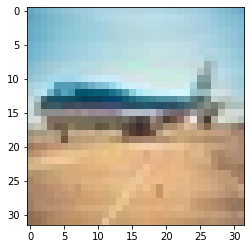

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


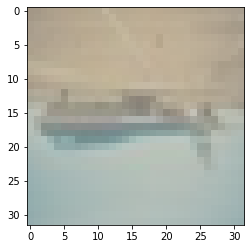

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


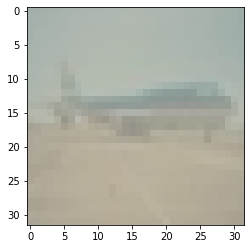

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


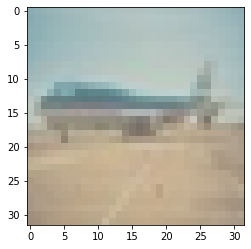

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


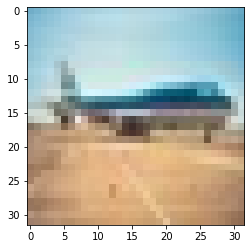

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


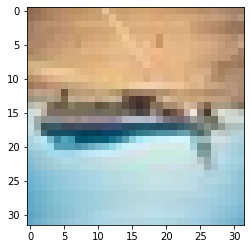

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


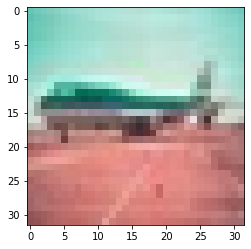

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


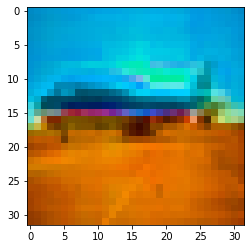

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


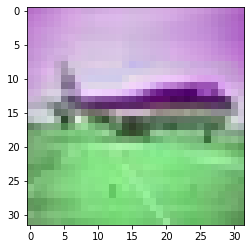

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


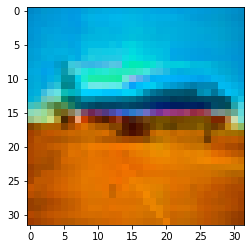

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
r = random.randint(0, 50000)
for i in range(augment_num):
    plt.imshow(augmented_data[r * augment_num + i].astype(int))
    plt.show()
    print(augmented_labels[r * augment_num + i])

In [42]:
augmentedExamplesForClass = []
for i in range(10):
    augmentedExamplesForClass.append([j for j in range(50000 * augment_num) if np.where(augmented_labels[j] == 1)[0][0] == i])

In [32]:
examplesForClass = []
for i in range(10):
    examplesForClass.append([j for j in range(50000 * rotations_num) if np.where(true_labels[j] == 1)[0][0] == i])

In [60]:
labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, 0, False)
self_supervised_train(unlabeled, 0)

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Train on 200000 samples, validate on 10000 samples
0.10000000149011612
Epoch 1/80
200000/200000 [==============================] - 39s 193us/sample - loss: 1.8534 - accuracy: 0.5425 - val_loss: 1.3575 - val_accuracy: 0.5953
0.10000000149011612
Epoch 2/80
200000/200000 [==============================] - 31s 156us/sample - loss: 1.2792 - accuracy: 0.6228 - val_loss: 1.1299 - val_accuracy: 0.6767
0.10000000149011612
Epoch 3/80
200000/200000 [==============================] - 31s 155us/sample - loss: 1.1827 - accuracy: 0.6600 - val_loss: 0.9589 - val_accuracy: 0.7890
0.10000000149011612
Epoch 4/80
200000/200000 [==============================] - 31s 157us/sample - loss: 1.1244 - accuracy: 0.6874 - val_loss: 1.0208 - val_accuracy: 0.7236
0.10000000149011612
Epoch 5/80
200000/200000 [==============================] - 31s 157us/sample - loss: 1.0775 - accuracy: 0.7079 - val_loss: 1.0560 - val_accuracy: 0.6992
0.10000000149011612
Epoch 6/80
200000/200000 [==============================] - 31s 

KeyboardInterrupt: 

In [59]:
logs = []
cls_logs = []

In [43]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    #if not os.path.isfile(saved_name + "_" + str(p)):
    
    if not os.path.isfile(saved_name):
        logs.append(self_supervised_train(unlabeled, p))
    cls_logs.append(fine_tune(labeled, p, True))        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
________________________________________________________________________

0.009999999776482582
Epoch 1/50
1500/1500 [==============================] - 4s 3ms/sample - loss: 10.6046 - acc: 0.3273 - val_loss: 15.4582 - val_acc: 0.1768
0.009999999776482582
Epoch 2/50
1500/1500 [==============================] - 1s 410us/sample - loss: 13.6980 - acc: 0.4667 - val_loss: 14.6588 - val_acc: 0.2321
0.009999999776482582
Epoch 3/50
1500/1500 [==============================] - 1s 384us/sample - loss: 11.4904 - acc: 0.5367 - val_loss: 11.6722 - val_acc: 0.2258
0.009999999776482582
Epoch 4/50
1500/1500 [==============================] - 1s 384us/sample - loss: 8.7993 - acc: 0.6467 - val_loss: 8.8152 - val_acc: 0.4094
0.009999999776482582
Epoch 5/50
1500/1500 [==============================] - 1s 409us/sample - loss: 7.1386 - acc: 0.6827 - val_loss: 8.1405 - val_acc: 0.3787
0.009999999776482582
Epoch 6/50
1500/1500 [==============================] - 1s 419us/sample - loss: 6.4967 - acc: 0.6720 - val_loss: 7.5708 - val_acc: 0.4384
0.009999999776482582
Epoch 7/50
1500/1500 

Train on 1000 samples, validate on 10000 samples
0.009999999776482582
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/sample - loss: 9.3610 - acc: 0.2890 - val_loss: 13.6362 - val_acc: 0.2814
0.009999999776482582
Epoch 2/50
1000/1000 [==============================] - 1s 534us/sample - loss: 13.4967 - acc: 0.4320 - val_loss: 14.8331 - val_acc: 0.2829
0.009999999776482582
Epoch 3/50
1000/1000 [==============================] - 1s 561us/sample - loss: 13.3852 - acc: 0.5820 - val_loss: 14.6288 - val_acc: 0.2258
0.009999999776482582
Epoch 4/50
1000/1000 [==============================] - 1s 567us/sample - loss: 11.7702 - acc: 0.6430 - val_loss: 12.4123 - val_acc: 0.2588
0.009999999776482582
Epoch 5/50
1000/1000 [==============================] - 1s 550us/sample - loss: 9.8409 - acc: 0.7320 - val_loss: 11.0833 - val_acc: 0.3021
0.009999999776482582
Epoch 6/50
1000/1000 [==============================] - 1s 532us/sample - loss: 8.3435 - acc: 0.7320 - val_loss: 10.1512 - val_ac

In [ ]:
#Self-supervised with augmentation

In [55]:
for p in labelsPercent:
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    print(len(labeled), len(unlabeled))
    cls_logs.append(fine_tune(labeled, p, True, True))        
#[0.5505, 0.6021, 0.6382, 0.6691, 0.7135, 0.7671, 0.8060, 0.8448]

5000 495000
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 3s 291us/sample - loss: 5.7803 - accuracy: 0.3406 - val_loss: 4.8413 - val_accuracy: 0.5424
Epoch 2/50
10000/10000 [==============================] - 1s 111us/sample - loss: 4.5303 - accuracy: 0.5410 - val_loss: 4.1478 - val_accuracy: 0.5817
Epoch 3/50
10000/10000 [==============================] - 1s 109us/sample - loss: 3.9015 - accuracy: 0.6371 - val_loss: 3.9441 - val_accuracy: 0.5821
Epoch 4/50
10000/10000 [==============================] - 1s 109us/sample - loss: 3.6827 - accuracy: 0.6862 - val_loss: 3.9362 - val_accuracy: 0.5828
Epoch 5/50
10000/10000 [==============================] - 1s 110us/sample - loss: 3.5266 - accuracy: 0.7314 - val_loss: 3.9201 - val_accuracy: 0.5883
Epoch 6/50
10000/10000 [==============================] - 1s 111us/sample - loss: 3.4439 - accuracy: 0.7654 - val_loss: 3.9733 - val_accuracy: 0.5773
Epoch 7/50
10000/10000 [==========================

Train on 15000 samples, validate on 10000 samples
Epoch 1/50
15000/15000 [==============================] - 3s 212us/sample - loss: 5.5103 - accuracy: 0.3709 - val_loss: 4.5035 - val_accuracy: 0.5477
Epoch 2/50
15000/15000 [==============================] - 2s 101us/sample - loss: 4.1452 - accuracy: 0.5493 - val_loss: 3.9215 - val_accuracy: 0.5691
Epoch 3/50
15000/15000 [==============================] - 2s 107us/sample - loss: 3.6969 - accuracy: 0.6305 - val_loss: 3.7746 - val_accuracy: 0.5962
Epoch 4/50
15000/15000 [==============================] - 2s 108us/sample - loss: 3.5485 - accuracy: 0.6762 - val_loss: 3.8176 - val_accuracy: 0.6039
Epoch 5/50
15000/15000 [==============================] - 2s 100us/sample - loss: 3.5486 - accuracy: 0.7072 - val_loss: 3.8636 - val_accuracy: 0.6000
Epoch 6/50
15000/15000 [==============================] - 2s 103us/sample - loss: 3.4839 - accuracy: 0.7411 - val_loss: 3.8546 - val_accuracy: 0.6024
Epoch 7/50
15000/15000 [==========================

Train on 25000 samples, validate on 10000 samples
Epoch 1/50
25000/25000 [==============================] - 4s 165us/sample - loss: 5.0678 - accuracy: 0.4115 - val_loss: 3.8560 - val_accuracy: 0.5984
Epoch 2/50
25000/25000 [==============================] - 2s 93us/sample - loss: 3.7768 - accuracy: 0.5698 - val_loss: 3.5218 - val_accuracy: 0.6232
Epoch 3/50
25000/25000 [==============================] - 2s 94us/sample - loss: 3.5649 - accuracy: 0.6193 - val_loss: 3.5505 - val_accuracy: 0.6235
Epoch 4/50
25000/25000 [==============================] - 2s 90us/sample - loss: 3.4909 - accuracy: 0.6554 - val_loss: 3.8342 - val_accuracy: 0.5705
Epoch 5/50
25000/25000 [==============================] - 2s 83us/sample - loss: 3.4465 - accuracy: 0.6809 - val_loss: 3.6498 - val_accuracy: 0.6208
Epoch 6/50
25000/25000 [==============================] - 2s 97us/sample - loss: 3.4317 - accuracy: 0.7036 - val_loss: 3.6186 - val_accuracy: 0.6388
Epoch 7/50
25000/25000 [==============================]

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 152us/sample - loss: 4.4235 - accuracy: 0.4880 - val_loss: 3.3526 - val_accuracy: 0.6631
Epoch 2/50
50000/50000 [==============================] - 5s 92us/sample - loss: 3.4012 - accuracy: 0.6043 - val_loss: 3.2233 - val_accuracy: 0.6419
Epoch 3/50
50000/50000 [==============================] - 5s 103us/sample - loss: 3.1956 - accuracy: 0.6498 - val_loss: 3.1516 - val_accuracy: 0.6572
Epoch 4/50
50000/50000 [==============================] - 5s 102us/sample - loss: 3.0927 - accuracy: 0.6784 - val_loss: 3.0705 - val_accuracy: 0.6793
Epoch 5/50
50000/50000 [==============================] - 5s 103us/sample - loss: 3.0515 - accuracy: 0.6984 - val_loss: 3.2550 - val_accuracy: 0.6491
Epoch 6/50
50000/50000 [==============================] - 5s 94us/sample - loss: 3.0199 - accuracy: 0.7218 - val_loss: 3.0983 - val_accuracy: 0.6924
Epoch 7/50
50000/50000 [============================

KeyboardInterrupt: 

In [76]:
for i in range(len(cls_logs)):
    print(cls_logs[i].history)

{'loss': [5.1621156904602055, 3.4491957165527345, 3.111892176437378, 2.836982766647339, 2.6537213677215576, 2.5163963864135743, 2.3845026907348634, 2.3148357666778563, 2.251161904144287, 2.1924621601867678, 2.1497454267883302, 2.1230961946868896, 2.095217316436768, 2.0404616275405885, 2.011863529129028, 1.9909101553344726, 1.9814020030593873, 1.9192924047088622, 1.899283710784912, 1.866166673927307, 0.8343204528808593, 0.6957590046691895, 0.7229805047416688, 0.7079862349891662, 0.7176088922500611, 0.687335565032959, 0.6569659146118164, 0.6600248963356018, 0.6057058526229858, 0.6159174393844604, 0.333522543258667, 0.20345580563545226, 0.19639107880592346, 0.1911460950088501, 0.1799638217306137, 0.18140056468963622, 0.2494173585700989, 0.19788443460464478, 0.20517555683135985, 0.2187417816734314, 0.13654079806804656, 0.1049133091878891, 0.10152696630001068, 0.09734066557884216, 0.09376265321493149, 0.08825974464416504, 0.09150181406021118, 0.08456231402397156, 0.08417600174427033, 0.0842

In [45]:
feat_log = self_supervised_train([i for i in range(50000 * rotations_num)], 0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Train on 200000 samples, validate on 40000 samples
0.10000000149011612
Epoch 1/100
200000/200000 [==============================] - 105s 524us/sample - loss: 1.7322 - acc: 0.5329 - val_loss: 1.4199 - val_acc: 0.5954
0.10000000149011612
Epoch 2/100
200000/200000 [==============================] - 99s 493us/sample - loss: 1.2233 - acc: 0.6318 - val_loss: 1.0686 - val_acc: 0.6477
0.10000000149011612
Epoch 3/100
200000/200000 [==============================] - 98s 489us/sample - loss: 0.9778 - acc: 0.6706 - val_loss: 0.9336 - val_acc: 0.6700
0.10000000149011612
Epoch 4/100
200000/200000 [==============================] - 94s 470us/sample - loss: 0.8634 - acc: 0.7002 - val_loss: 0.8934 - val_acc: 0.6769
0.10000000149011612
Epoch 5/100
200000/200000 [==============================] - 92s 461us/sample - loss: 0.7884 - acc: 0.7263 - val_loss: 0.8478 - val_acc: 0.6930
0.10000000149011612
Epoch 6/100
200000/200000 [==============================] - 97s 483us/sample - loss: 0.7256 - acc: 0.7493 -

200000/200000 [==============================] - 100s 498us/sample - loss: 0.0080 - acc: 0.9999 - val_loss: 1.5991 - val_acc: 0.7581
0.0007999999215826392
Epoch 100/100
200000/200000 [==============================] - 100s 499us/sample - loss: 0.0082 - acc: 0.9999 - val_loss: 1.6199 - val_acc: 0.7580


In [26]:
model = tf.keras.models.load_model('selfsupervised_50_backup2')
model.summary()
l = model.get_layer('conv_feat').output
feat = tf.keras.Model(inputs = model.input, outputs = l)
y_pred = []

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
________________________________________________________________________

In [28]:
features_test = feat.predict(np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)]))

In [32]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    features = feat.predict(np.asarray([combined_data[i] for i in labeled]))
    clf = svm.SVC(C = 100., kernel = 'rbf')
    clf.fit(features, np.asarray([np.argmax(true_labels[i]) for i in labeled]))
    y_pred.append(clf.predict(features_test))
    print(metrics.accuracy_score(np.asarray([np.argmax(true_labels[(50000 + i) * rotations_num]) for i in range(10000)]), y_pred[-1]))

C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ValueError: Found input variables with inconsistent numbers of samples: [10000, 1]

In [77]:
plot_dict = {}

for i, p in enumerate(labelsPercent):
    plot_dict["labels_" + str(p)] = cls_logs[i].history['val_acc']

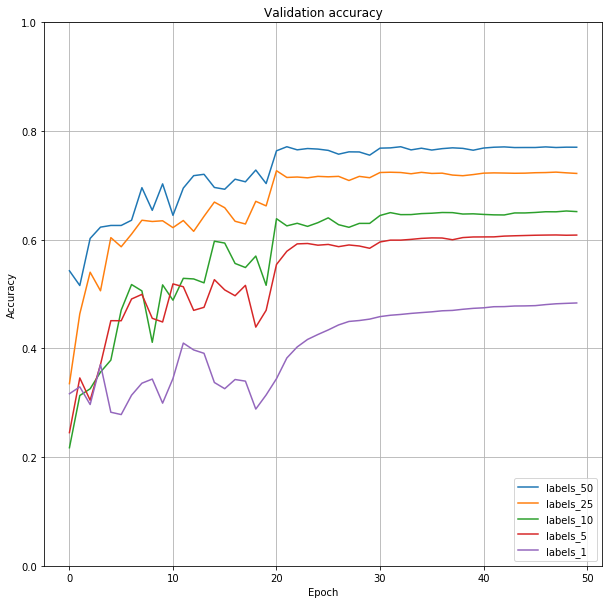

In [78]:
plot_training(name = 'Validation accuracy',
              filename = 'self_part_labels',
              **plot_dict)

In [48]:
selfsupervised_acc = {}

In [49]:
for i, p in enumerate(labelsPercent):
    selfsupervised_acc[p] = cls_logs[i].history['val_acc'][-1]
print(selfsupervised_acc)

{100: 0.8168, 50: 0.7677, 25: 0.7204, 10: 0.6401, 5: 0.6005, 1: 0.482, 3: 0.5648, 2: 0.5198}


In [100]:
emptyResNet = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
emptyResNet.summary()
emptyResNet.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
emptyResNet.save('emptyResNet')

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: emptyResNet\assets


In [54]:
mycnn = get_feat_model()
mycnn.summary()
mycnn.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
mycnn.save(cnn_name)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 32)        0   

In [68]:
logs_supervised = []
cls_logs_supervised = []

In [45]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    cls_logs_supervised.append(fine_tune(labeled, p, True, False))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

0.009999999776482582
Epoch 1/50
1500/1500 [==============================] - 4s 2ms/sample - loss: 10.9415 - acc: 0.2320 - val_loss: 16.2020 - val_acc: 0.0997
0.009999999776482582
Epoch 2/50
1500/1500 [==============================] - 1s 420us/sample - loss: 14.1160 - acc: 0.3273 - val_loss: 15.7749 - val_acc: 0.1033
0.009999999776482582
Epoch 3/50
1500/1500 [==============================] - 1s 447us/sample - loss: 11.9760 - acc: 0.3993 - val_loss: 13.8559 - val_acc: 0.1168
0.009999999776482582
Epoch 4/50
1500/1500 [==============================] - 1s 417us/sample - loss: 9.2296 - acc: 0.4453 - val_loss: 9.6490 - val_acc: 0.1547
0.009999999776482582
Epoch 5/50
1500/1500 [==============================] - 1s 419us/sample - loss: 7.3037 - acc: 0.4793 - val_loss: 9.1668 - val_acc: 0.1344
0.009999999776482582
Epoch 6/50
1500/1500 [==============================] - 1s 431us/sample - loss: 6.1229 - acc: 0.5107 - val_loss: 8.9302 - val_acc: 0.1054
0.009999999776482582
Epoch 7/50
1500/1500 

Train on 1000 samples, validate on 10000 samples
0.009999999776482582
Epoch 1/50
1000/1000 [==============================] - 4s 4ms/sample - loss: 9.5924 - acc: 0.2220 - val_loss: 14.2678 - val_acc: 0.1084
0.009999999776482582
Epoch 2/50
1000/1000 [==============================] - 1s 584us/sample - loss: 13.9113 - acc: 0.3270 - val_loss: 16.1059 - val_acc: 0.1037
0.009999999776482582
Epoch 3/50
1000/1000 [==============================] - 1s 581us/sample - loss: 14.1856 - acc: 0.3820 - val_loss: 15.7970 - val_acc: 0.1003
0.009999999776482582
Epoch 4/50
1000/1000 [==============================] - 1s 577us/sample - loss: 12.7087 - acc: 0.4840 - val_loss: 14.0557 - val_acc: 0.1131
0.009999999776482582
Epoch 5/50
1000/1000 [==============================] - 1s 574us/sample - loss: 10.7536 - acc: 0.5300 - val_loss: 12.3342 - val_acc: 0.0905
0.009999999776482582
Epoch 6/50
1000/1000 [==============================] - 1s 570us/sample - loss: 8.9384 - acc: 0.5900 - val_loss: 11.2957 - val_a

In [164]:
#Supervised with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=4,
    height_shift_range=4, 
    brightness_range=[0.5, 1.0],
    preprocessing_function=my_preprocess)
datagen.fit(combined_data)

In [101]:
for p in labelsPercent:
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    print(len(labeled))
    print(len(unlabeled))
    cls_logs_supervised.append(fine_tune(labeled, p, True, False))

500000
0
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________

Train on 500000 samples, validate on 10000 samples
Epoch 1/50
500000/500000 [==============================] - 53s 105us/sample - loss: 2.8735 - accuracy: 0.5410 - val_loss: 2.5375 - val_accuracy: 0.6202
Epoch 2/50
500000/500000 [==============================] - 50s 99us/sample - loss: 2.3127 - accuracy: 0.6893 - val_loss: 2.0932 - val_accuracy: 0.7488
Epoch 3/50
500000/500000 [==============================] - 49s 99us/sample - loss: 2.1268 - accuracy: 0.7383 - val_loss: 2.0022 - val_accuracy: 0.7497
Epoch 4/50
500000/500000 [==============================] - 50s 99us/sample - loss: 1.9702 - accuracy: 0.7670 - val_loss: 1.9627 - val_accuracy: 0.7492
Epoch 5/50
500000/500000 [==============================] - 50s 99us/sample - loss: 1.8240 - accuracy: 0.7855 - val_loss: 1.7723 - val_accuracy: 0.7840
Epoch 6/50
500000/500000 [==============================] - 50s 99us/sample - loss: 1.7019 - accuracy: 0.8014 - val_loss: 1.6935 - val_accuracy: 0.7883
Epoch 7/50
500000/500000 [==========

InternalError: GPU sync failed

In [223]:
supervised_acc = {}

In [224]:
for i, p in enumerate(labelsPercent):
    if i < len(cls_logs_supervised):
        supervised_acc[p] = cls_logs_supervised[i].history['val_accuracy'][-1]
        
print(supervised_acc)
#{100: 0.8076, 50: 0.7702, 25: 0.7134, 10: 0.6265, 5: 0.5556, 1: 0.3892, 3: 0.4811, 2: 0.4377}
#{1: 0.4231, 2: 0.5026, 3: 0.5475, 5: 0.6002, 10: 0.6714, 25: 0.7411, 50: 0.7959, 100: 0.8420}

{1: 0.4231, 2: 0.5026, 3: 0.5475, 5: 0.6002, 10: 0.6714, 25: 0.7411, 50: 0.7959}


In [68]:
super_v = []
self_v = []

for p in labelsPercent:
    super_v.append(supervised_acc[p])
    self_v.append(selfsupervised_acc[p])

In [170]:
samplesPerClass = []
for p in labelsPercent:
    samplesPerClass.append(5000 * p // 100)
print(samplesPerClass)

[50, 100, 150, 250, 500, 1250, 2500, 5000]


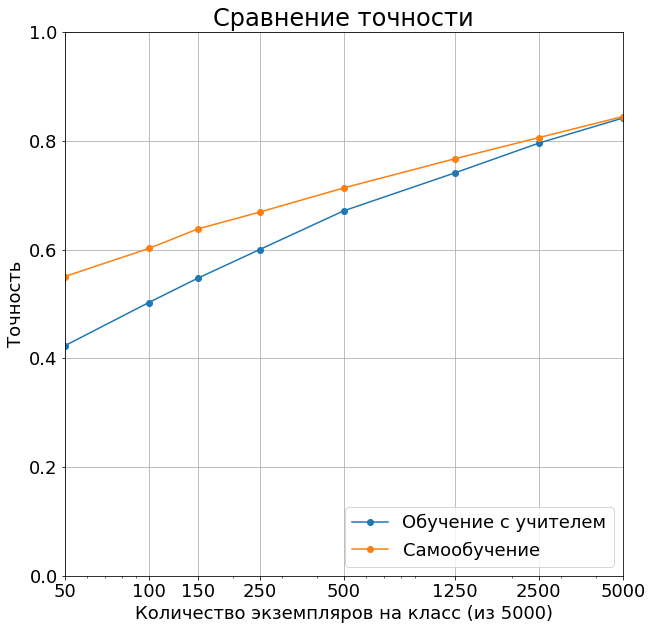

In [179]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(samplesPerClass, super_v, 'o-', label='Обучение с учителем')
ax.plot(samplesPerClass, self_v, 'o-', label='Самообучение')
ax.grid(True)
plt.title('Сравнение точности', size = 24)
plt.xlabel('Количество экземпляров на класс (из 5000)', fontsize = 18)
plt.ylabel('Точность', fontsize = 18)
plt.xscale("log")
ax.axis([min(samplesPerClass), max(samplesPerClass), 0., 1.])
ax.set_xticks(samplesPerClass)
ax.tick_params(labelsize= 18)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.legend(loc='lower right', fontsize = 18)
plt.savefig('acc_compare_3')

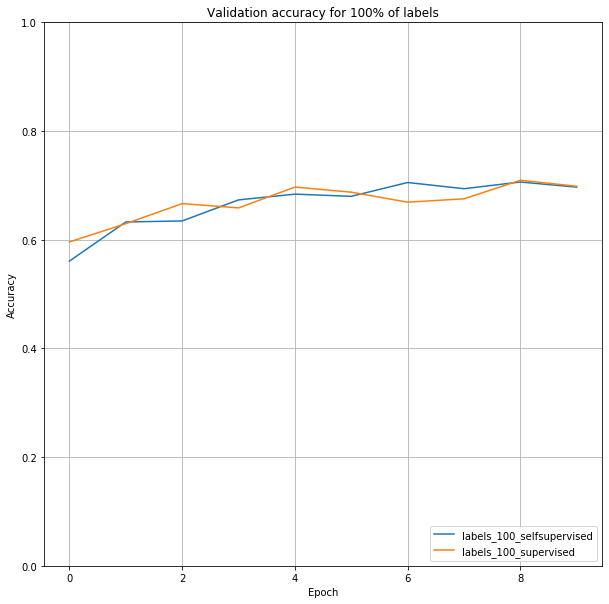

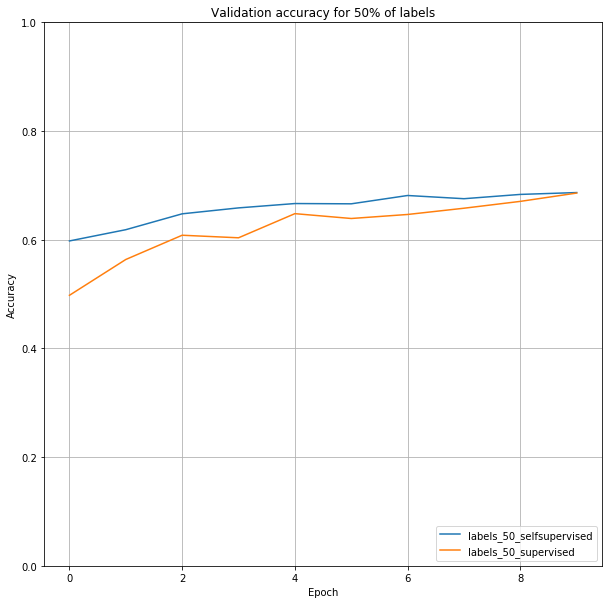

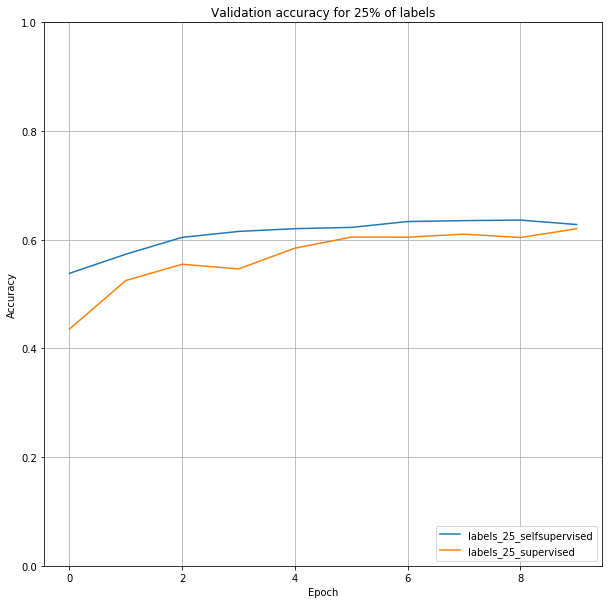

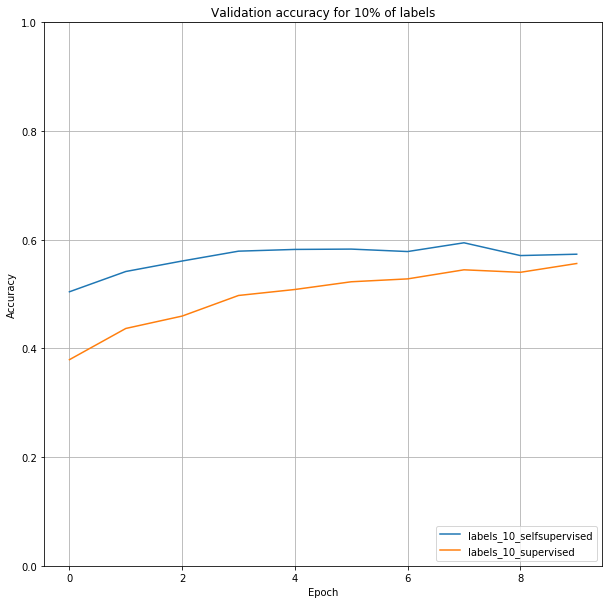

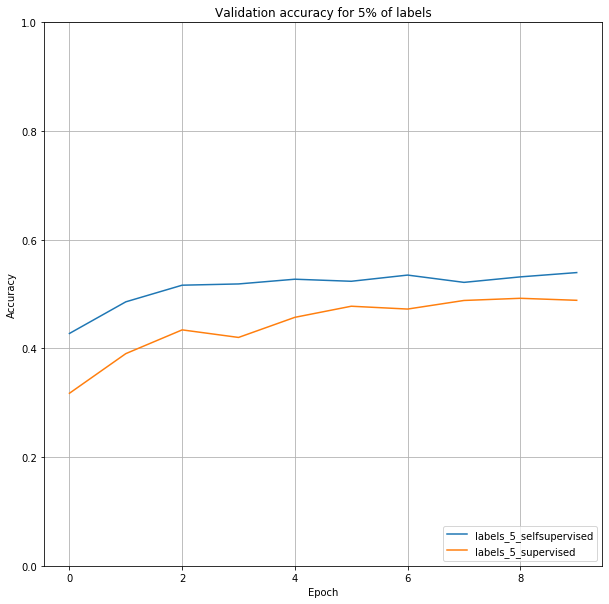

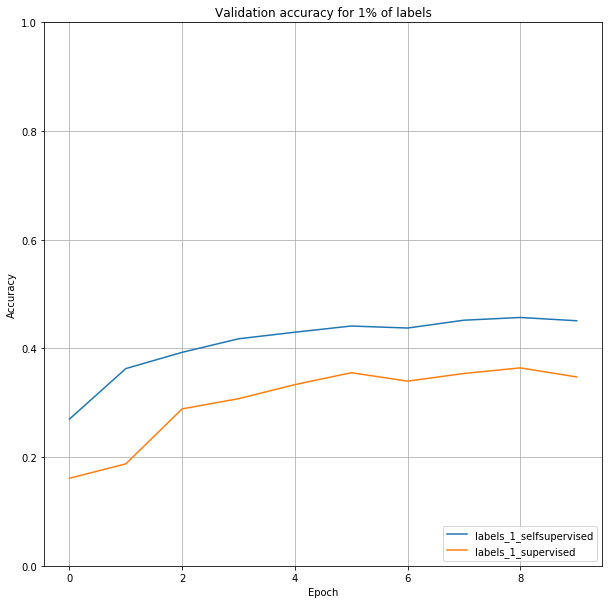

In [ ]:
for i, p in enumerate(labelsPercent):
    plot_dict = {}
    
    plot_dict["labels_" + str(p) + "_selfsupervised"] = cls_logs[i].history['val_acc']
    plot_dict["labels_" + str(p) + "_supervised"] = cls_logs_supervised[i].history['val_acc']
    
    plot_training(name = 'Validation accuracy for ' + str(p) + "% of labels",
                  filename = 'self_and_default_' + str(p) + " labels",
                  **plot_dict)

In [139]:
unsupervised_threshold = 0.95
unsupervised_loss_coef = 1.0
unlabeled_epoch_start = 5

semisupervised_epochs = 50
semisupervised_batch_size = 128

In [85]:
labelsPercent = [50, 25, 10, 5, 3, 2, 1] #100

In [33]:
class Augmentator():
    def shearX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, (random.choice([-1, 1])) * self.M * 0.3, 0, 0, 1, 0))

    def shearY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, (random.choice([-1, 1])) * self.M * 0.3, 1, 0))

    def translateX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, (random.choice([-1, 1])) * self.M * 0.3 * img.size[0], 0, 1, 0))

    def translateY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, (random.choice([-1, 1])) * self.M * 0.3 * img.size[0]))

    def rotate(self, img):
        return img.rotate((random.choice([-1, 1])) * self.M * 30.0)

    def autoContrast(self, img):
        return PIL.ImageOps.autocontrast(img)

    def invert(self, img):
        return PIL.ImageOps.invert(img)

    def equalize(self, img):
        return PIL.ImageOps.equalize(img)

    def solarize(self, img):
        return PIL.ImageOps.solarize(img, self.M * 256.0)

    def posterize(self, img):
        return PIL.ImageOps.posterize(img, int(self.M * 4.0))

    def contrast(self, img):
        return PIL.ImageEnhance.Contrast(img).enhance(self.M)

    def color(self, img):
        return PIL.ImageEnhance.Color(img).enhance(self.M)

    def brightness(self, img):
        return PIL.ImageEnhance.Brightness(img).enhance(self.M)

    def sharpness(self, img):
        return PIL.ImageEnhance.Sharpness(img).enhance(self.M)
    
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.transformations = [self.autoContrast, self.equalize, self.rotate, self.solarize, self.color, self.posterize, self.contrast, self.brightness, self.sharpness, self.shearX, self.shearY, self.translateX, self.translateY]

    def __call__(self, img):
        chosen_transformations = random.choices(self.transformations, k = self.N)
        for f in chosen_transformations:
            img = f(img)
        return img


In [34]:
def is_called(func):
    def newfunc(*args, **kwargs):
        print('Called func!')
        func(args, kwargs)
    return newfunc

In [35]:
def custom_loss(y_true, y_pred):
    with tf.GradientTape() as tape:
        return tf.math.reduce_sum(tf.multiply(y_true, tf.math.log(y_pred)))

In [36]:
#loss_tracker = metrics.CategoricalCrossentropy(name="loss")
acc_metric = tf.keras.metrics.Accuracy(name="acc")

#loss_tracker_supervised = metrics.CategoricalCrossentropy(name="loss_sup")
acc_metric_supervised = tf.keras.metrics.Accuracy(name="acc_sup")

#loss_tracker_unsupervised = metrics.CategoricalCrossentropy(name="loss_unsup")
acc_metric_unsupervised = tf.keras.metrics.Accuracy(name="acc_unsup")


class CustomModel(Model):
    @is_called
    def train_step(self, data):
        X, Y = data
        print(X)
        X = tf.unstack(X)

        print('Going to tape')

        x_supervised = np.asarray([combined_data[i] for i in X if i in labeled])
        x_unsupervised = np.asarray([combined_data[i] for i in X if i in unlabeled])
        x_augmented = x_unsupervised
        y_true_supervised = np.asarray([true_labels[i] for i in X if i in labeled])

        #Supervised part
        with tf.GradientTape() as tape:
            tape.watch(x_supervised)

            y_pred_supervised = self(x_supervised, training=True)  
            loss_supervised = custom_loss(y_true_supervised, y_pred_supervised)

            #Unsupervised part
            tape.watch(x_augmented)
            y_pred = self(x_unsupervised, training=False)

            #y_pred_np = tf.make_ndarray(y_pred.op.get_attr('value'))
            y_pred_unsupervised = self(x_augmented, training=True) #if max(y_pred_np[i]) > unsupervised_threshold)
            
            loss_unsupervised = custom_loss(y_pred, y_pred_unsupervised)

            #Loss
            #loss, grads = custom_loss(self, y_true_supervised, y_pred, y_pred_supervised, y_pred_unsupervised)
            loss = loss_supervised + loss_unsupervised * unsupervised_loss_coef
            grads = tape.gradient(loss, self.trainable_variables)

            #Weights
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        #Metrics
        #loss_tracker_supervised.update_state(loss_supervised)
        acc_metric_supervised.update_state(y_true_supervised, y_pred_supervised)

        #loss_tracker_unsupervised.update_state(loss_unsupervised)
        acc_metric_unsupervised.update_state(y_pred, y_pred_unsupervised)

        #loss_tracker.update_state(loss)
        #acc_metric.update_state(np.concatenate(y_pred, y_true_supervised), np.concatenate(y_pred_unsupervised, y_pred_supervised))

        return {#"loss_supervised": loss_tracker_supervised.result(), 
                "acc_supervised": acc_metric_supervised.result(), 
                #"loss_unsupervised": loss_tracker_unsupervised.result(), 
                "acc_unsupervised": acc_metric_unsupervised.result()}

    @property
    def metrics(self):
        return [#loss_tracker, 
            acc_metric]



In [143]:
augmentator = Augmentator(2, random.random())

In [144]:
pil_data = np.zeros(augmented_data.shape, dtype = np.float32)

In [12]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[data_len * i + j][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            rotated_data[data_len * i + j][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
            
        rotated_data[data_len * i + j] = np.rot90(rotated_data[data_len * i + j], random.choice([0, 1, 2, 3]))

In [145]:
for i in range(pil_data.shape[0]):
    if i % 10000 == 0:
        print(i)
    pil_data[i] = np.array(augmentator(Image.fromarray(np.uint8(augmented_data[i // augment_num * augment_num]))))


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000


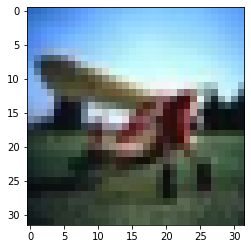

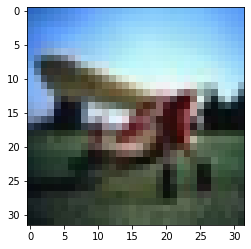

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


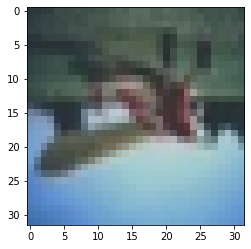

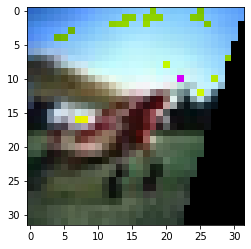

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


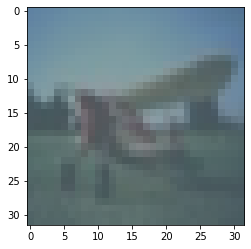

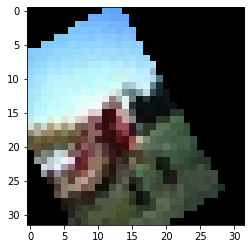

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


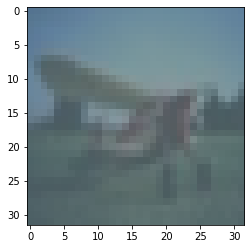

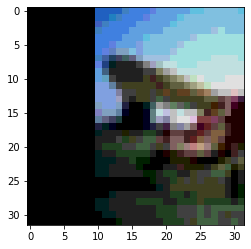

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


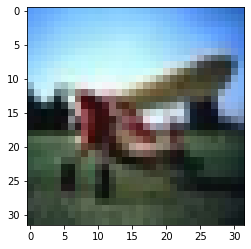

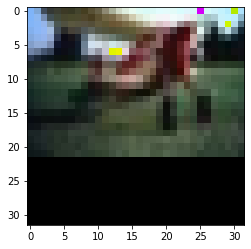

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


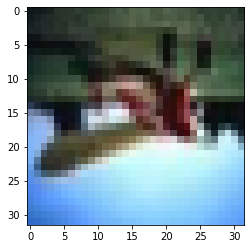

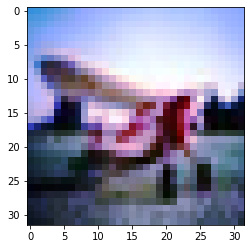

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


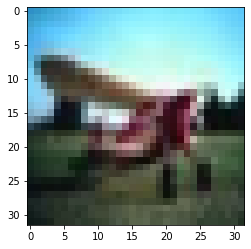

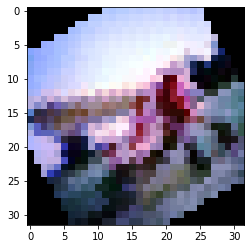

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


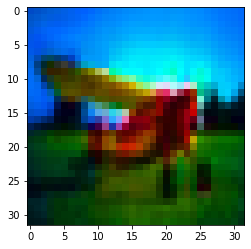

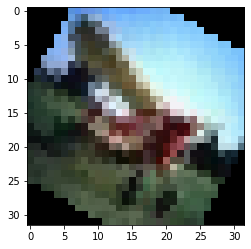

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


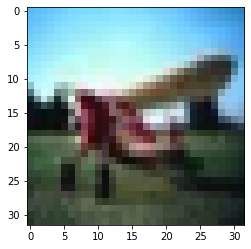

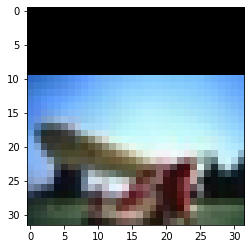

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


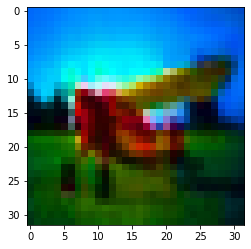

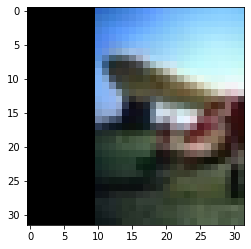

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [146]:
r = random.randint(0, pil_data.shape[0] // augment_num)
for i in range(augment_num):
    plt.imshow(augmented_data[r * augment_num + i].astype(int))
    plt.show()
    plt.imshow(pil_data[r * augment_num + i].astype(int))
    plt.show()
    print(augmented_labels[r + i])

In [43]:
#rotated_data = preprocess_input(rotated_data)
#pil_data = preprocess_input(pil_data)

In [44]:
augmentedExamplesForClass = []
for i in range(10):
    augmentedExamplesForClass.append([j for j in range(50000 * augment_num) if np.where(augmented_labels[j] == 1)[0][0] == i])

In [ ]:
def get_basic_conv_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), name = 'conv_feat')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(10, activation = 'softmax')(x)
    
    return CustomModel(inputs = inputs, outputs = x)

In [45]:
def get_resnet_model():
    base = tf.keras.models.load_model('emptyResNet')
    l = base.get_layer(feature_layer).output
    l = layers.Flatten()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001), activation = 'softmax')(l)

    return tf.keras.Model(inputs = base.input, outputs = l)

In [46]:
import time

In [47]:
def generate_labeled_unlabeled_semi(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    labeled_nums = [i for i in range(5000 - percent * 50, 5000)]
    unlabeled_nums = [i for i in range(5000 - percent * 50)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [48]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [156]:
#SEMI-SUPERVISED LEARNING

val_indices = [(50000 + i) * rotations_num for i in range(10000)]
x_val = tf.convert_to_tensor(np.take(combined_data, val_indices, axis = 0) / 256.)
y_val = tf.convert_to_tensor(np.take(true_labels, val_indices, axis = 0))

for p in labelsPercent:
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            #loss_value = custom_loss(y, logits)
            loss_value = loss(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value
    
    @tf.function
    def val_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)
    
    print('%d%% of labeled data' % p)
    model = get_cls_model(saved_name, False)
    model.summary()
    
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    
    #Custom training loop
    for epoch in range(semisupervised_epochs):
        above_threshold_num = 0
        start_time = time.time()
        random.shuffle(labeled)
        random.shuffle(unlabeled)
        print("\nEpoch " + str(epoch) + "/" + str(semisupervised_epochs))
        start_time = time.time()
        
        for step_num in range(augmented_data.shape[0] // semisupervised_batch_size):
            print('Processing step %d/%d, train_acc = %.4f\r' % (step_num, augmented_data.shape[0] // semisupervised_batch_size, float(train_acc_metric.result())), end="")
            labeled_batch_indices = labeled[step_num * semisupervised_batch_size * p // 100 : (step_num + 1) * semisupervised_batch_size * p // 100 ]
            unlabeled_batch_indices = unlabeled[step_num * semisupervised_batch_size * (100 - p) // 100 : (step_num + 1) * semisupervised_batch_size * (100 - p) // 100 ]
            loss_value_labeled = train_step(tf.convert_to_tensor(np.take(augmented_data, labeled_batch_indices, axis = 0) / 256.), 
                                            tf.convert_to_tensor(np.take(augmented_labels, labeled_batch_indices, axis = 0)))
         
            if epoch >= unlabeled_epoch_start:
                x_batch_unlabeled = tf.convert_to_tensor(np.take(augmented_data, unlabeled_batch_indices, axis = 0) / 256.)
                y_true_unlabeled = model(x_batch_unlabeled, training=False)
                
                #check threshold
                indices_above_threshold = np.take(unlabeled_batch_indices, tf.where(tf.reduce_max(y_true_unlabeled, axis = 1) > unsupervised_threshold)).flatten()
                loss_value_unlabeled = 0.0
                if indices_above_threshold.shape[0] > 0:
                    above_threshold_num += indices_above_threshold.shape[0]
                    loss_value_unlabeled = train_step(tf.convert_to_tensor(np.take(pil_data, indices_above_threshold, axis = 0) / 256.), 
                                                      tf.cast(tf.convert_to_tensor(np.take(y_true_unlabeled.numpy(), tf.where(tf.reduce_max(y_true_unlabeled, axis = 1) > unsupervised_threshold).numpy().flatten(), axis = 0)) + 0.5, tf.int32))

            
            #print('Step ' + str(step) + ' Loss: ' + str(loss_value_labeled) + ' | ' + str(loss_value_unlabeled))
            
            #optimizer.lr.assign(lr_schedule_conv(optimizer.lr, epoch))
              
        print("\nTraining acc over epoch: %.4f" % (float(train_acc_metric.result()),))
        
        val_step(x_val, y_val)
        print("Val acc over epoch: %.4f" % (float(val_acc_metric.result()),))

        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        
        print("%d/%d unlabeled samples are used" % (above_threshold_num, len(unlabeled)))
        print("%s seconds for epoch" % (time.time() - start_time))

1% of labeled data
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
________________________________________________________________________


Epoch 0/50
Processing step 3905/3906, train_acc = 0.1006
Training acc over epoch: 0.1006
Val acc over epoch: 0.1370
0/495000 unlabeled samples are used
34.065080642700195 seconds for epoch

Epoch 1/50
Processing step 3905/3906, train_acc = 0.1052
Training acc over epoch: 0.1052
Val acc over epoch: 0.1258
0/495000 unlabeled samples are used
29.30400037765503 seconds for epoch

Epoch 2/50


KeyboardInterrupt: 

In [165]:
#FINE-TUNING AFTER SELF-SUPERVISED

val_indices = [(50000 + i) * rotations_num for i in range(10000)]
x_val = tf.convert_to_tensor(np.take(combined_data, val_indices, axis = 0) / 256.)
y_val = tf.convert_to_tensor(np.take(true_labels, val_indices, axis = 0))

for p in [3, 25, 50]:
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            #loss_value = custom_loss(y, logits)
            loss_value = loss(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, logits)
        return loss_value
    
    @tf.function
    def val_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)

    print('%d%% of labeled data' % p)
    model = get_cls_model(saved_name, True)
    model.summary()
    
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    
    #Custom training loop
    for epoch in range(semisupervised_epochs):
        above_threshold_num = 0
        start_time = time.time()
        random.shuffle(labeled)
        print("\nEpoch " + str(epoch) + "/" + str(semisupervised_epochs))
        start_time = time.time()
        
        for step_num in range(len(labeled) // semisupervised_batch_size):
            print('Processing step %d/%d, train_acc = %.4f\r' % (step_num, augmented_data.shape[0] // semisupervised_batch_size, float(train_acc_metric.result())), end="")
            labeled_batch_indices = labeled[step_num * semisupervised_batch_size: (step_num + 1) * semisupervised_batch_size]
            loss_value_labeled = train_step(tf.convert_to_tensor(np.take(augmented_data, labeled_batch_indices, axis = 0) / 256.), 
                                            tf.convert_to_tensor(np.take(augmented_labels, labeled_batch_indices, axis = 0)))
         
           
            #print('Step ' + str(step) + ' Loss: ' + str(loss_value_labeled) + ' | ' + str(loss_value_unlabeled))
            
        #optimizer.lr.assign(lr_schedule_cls(optimizer.lr, epoch))
              
        print("\nTraining acc over epoch: %.4f" % (float(train_acc_metric.result()),))
        
        val_step(x_val, y_val)
        print("Val acc over epoch: %.4f" % (float(val_acc_metric.result()),))

        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        
        print("%d/%d unlabeled samples are used" % (above_threshold_num, len(unlabeled)))
        print("%s seconds for epoch" % (time.time() - start_time))

3% of labeled data
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
________________________________________________________________________


Epoch 0/50
Processing step 116/3906, train_acc = 0.4137
Training acc over epoch: 0.4144
Val acc over epoch: 0.5944
0/485000 unlabeled samples are used
5.646474599838257 seconds for epoch

Epoch 1/50
Processing step 116/3906, train_acc = 0.6136
Training acc over epoch: 0.6134
Val acc over epoch: 0.6090
0/485000 unlabeled samples are used
2.066498279571533 seconds for epoch

Epoch 2/50
Processing step 116/3906, train_acc = 0.7146
Training acc over epoch: 0.7151
Val acc over epoch: 0.6393
0/485000 unlabeled samples are used
2.0290019512176514 seconds for epoch

Epoch 3/50
Processing step 116/3906, train_acc = 0.7885
Training acc over epoch: 0.7887
Val acc over epoch: 0.6233
0/485000 unlabeled samples are used
2.0380008220672607 seconds for epoch

Epoch 4/50
Processing step 116/3906, train_acc = 0.8439
Training acc over epoch: 0.8440
Val acc over epoch: 0.6284
0/485000 unlabeled samples are used
2.0274970531463623 seconds for epoch

Epoch 5/50
Processing step 116/3906, train_acc = 0.8691



Epoch 0/50
Processing step 975/3906, train_acc = 0.5628
Training acc over epoch: 0.5630
Val acc over epoch: 0.6728
0/375000 unlabeled samples are used
20.067198276519775 seconds for epoch

Epoch 1/50
Processing step 975/3906, train_acc = 0.6923
Training acc over epoch: 0.6923
Val acc over epoch: 0.7353
0/375000 unlabeled samples are used
15.344001293182373 seconds for epoch

Epoch 2/50
Processing step 975/3906, train_acc = 0.7466
Training acc over epoch: 0.7466
Val acc over epoch: 0.7490
0/375000 unlabeled samples are used
15.804502248764038 seconds for epoch

Epoch 3/50
Processing step 975/3906, train_acc = 0.7854
Training acc over epoch: 0.7854
Val acc over epoch: 0.7512
0/375000 unlabeled samples are used
15.922500371932983 seconds for epoch

Epoch 4/50
Processing step 975/3906, train_acc = 0.8152
Training acc over epoch: 0.8151
Val acc over epoch: 0.7551
0/375000 unlabeled samples are used
15.993499517440796 seconds for epoch

Epoch 5/50
Processing step 975/3906, train_acc = 0.838


Epoch 0/50
Processing step 1952/3906, train_acc = 0.6086
Training acc over epoch: 0.6087
Val acc over epoch: 0.7399
0/250000 unlabeled samples are used
35.556352615356445 seconds for epoch

Epoch 1/50
Processing step 1952/3906, train_acc = 0.7207
Training acc over epoch: 0.7207
Val acc over epoch: 0.7727
0/250000 unlabeled samples are used
36.441017627716064 seconds for epoch

Epoch 2/50
Processing step 1952/3906, train_acc = 0.7645
Training acc over epoch: 0.7645
Val acc over epoch: 0.7690
0/250000 unlabeled samples are used
36.4081494808197 seconds for epoch

Epoch 3/50
Processing step 1952/3906, train_acc = 0.7953
Training acc over epoch: 0.7953
Val acc over epoch: 0.7842
0/250000 unlabeled samples are used
36.556079149246216 seconds for epoch

Epoch 4/50
Processing step 1952/3906, train_acc = 0.8170
Training acc over epoch: 0.8170
Val acc over epoch: 0.7935
0/250000 unlabeled samples are used
34.25800156593323 seconds for epoch

Epoch 5/50
Processing step 1952/3906, train_acc = 0.

KeyboardInterrupt: 